# Windturbine data from a SCADA system sampled every 10 minutes
---
You can find this dataset in [Kaggle](https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset)

**The variables are :**
- Active Power
- Wind Speed
- Theoretical Power
- Wind Direction




In [2]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from empiricaldist import Pmf
from empiricaldist import Cdf
import seaborn as sns
from scipy.stats import linregress
import statsmodels.formula.api as smf

### We are going to import the data, rename some columns and make an new column named hours
---

In [3]:
# This has data for power generation by a wind turbine during 2018 every 10 minutes
df=pd.read_csv("T1.csv")
print(df.head())
print(df.shape)
print(df.dtypes)

          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
(50530, 5)
Date/Time                         object
LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
dtype: object


In [4]:
#Renaming the Columns for easier programming
##ap=LV Active Power
##ws=Wind Speed
##tp=theoretical Power
##wd=Wind Direction
df=df.rename(columns={'Date/Time':'date','LV ActivePower (kW)':'ap','Wind Speed (m/s)':'ws','Theoretical_Power_Curve (KWh)':'tp','Wind Direction (°)':'wd'})
print(df.head())

               date          ap        ws          tp          wd
0  01 01 2018 00:00  380.047791  5.311336  416.328908  259.994904
1  01 01 2018 00:10  453.769196  5.672167  519.917511  268.641113
2  01 01 2018 00:20  306.376587  5.216037  390.900016  272.564789
3  01 01 2018 00:30  419.645905  5.659674  516.127569  271.258087
4  01 01 2018 00:40  380.650696  5.577941  491.702972  265.674286


In [5]:
#convert data to Integers
convert={'ap':int,'ws':int,'tp':int,'wd':int}
df[["ap","ws","tp","wd"]]=df[["ap","ws","tp","wd"]].astype(convert)

In [6]:
#convert Date to Datetime object
df["date"]=pd.to_datetime(df['date'],format='%d %m %Y %H:%M')

In [7]:
#Find missing values
df.isna().any() 

date    False
ap      False
ws      False
tp      False
wd      False
dtype: bool

In [8]:
#Create a new column named "hours" with only the hours, not dates
df["hours"]=df['date'].dt.strftime("%H:%M")


In [9]:
#Let explore variables

## Variable Analysis
---

#### Histogram from  Active Power
Just from the histogram we can se that there is no normal distribution as we have a peak betwen 0 to 500 and anoter around 3000 to 3500

In [10]:
df['ap'].describe()

count    50530.000000
mean      1307.291649
std       1312.350656
min         -2.000000
25%         50.000000
50%        825.000000
75%       2482.000000
max       3618.000000
Name: ap, dtype: float64

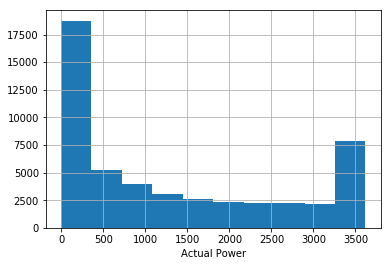

In [89]:

plt.xlabel("Actual Power")
df['ap'].hist()

### Lets explore more in dept values on the range of 0 to 1000 kw
The count is  around **half** all the sampled data every 10 minutes.
and we see that 25% of the time is not producing electricity by looking at the first Quartile

count    27146.000000
mean       246.007478
std        302.061049
min         -2.000000
25%          0.000000
50%         88.000000
75%        455.000000
max       1000.000000
Name: ap, dtype: float64


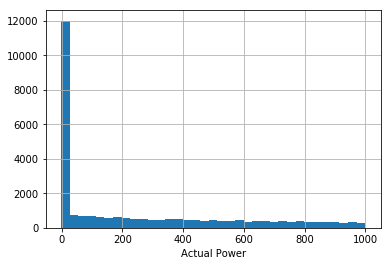

In [88]:
# Get rows less than a 1000 kw
range_1000=df[df['ap']<=1000]
print(range_1000['ap'].describe())
# Plot the histogram of values less than 1000 kw

plt.xlabel("Actual Power")
range_1000['ap'].hist(bins=35)


#### By doing the Cumulative Distribution Function we can confirm the the value of 0 has 20% probabilty.

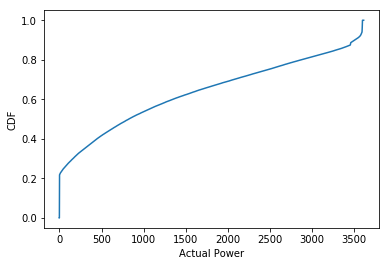

In [13]:
cdf=Cdf.from_seq(df['ap'])
cdf.plot()
plt.xlabel('Actual Power')
plt.ylabel('CDF')
plt.show()

#### To summarize

From the count for 0 kw we get 10943 events. These events equals 1823 hours where the turbin is not generating power.
In conclusion around 20% of the year the wind turbine will deliver 0 power




In [14]:
# Get count of 0 hours events
producing0=df[df['ap']==0]
print(producing0['ap'].value_counts())

0    10943
Name: ap, dtype: int64


#### Histogram from Wind Speed
We can see on this variable that the mean speed is 7 m/s. We can prove that with the big peak on the histogram

count    50530.000000
mean         7.058342
std          4.236638
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         25.000000
Name: ws, dtype: float64


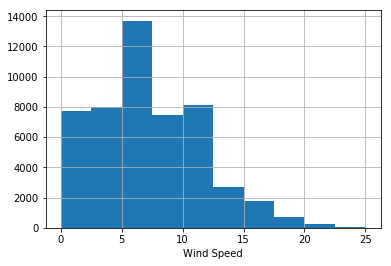

In [87]:
print(df['ws'].describe())

plt.xlabel("Wind Speed")
df['ws'].hist()

### To get a better perspective of this variable we will do a probability mass function

### Wind Speed Variable
we se a constant distribution between the 0 and 15 m/s. and a peak around  5 to 7 ms.
The mean is 7 m/s 

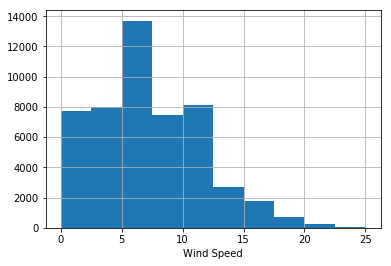

In [86]:

plt.xlabel("Wind Speed")
df['ws'].hist()

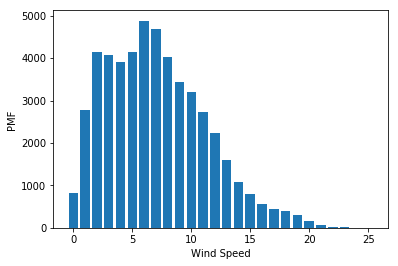

In [85]:

wind=df['ws']

pmf_wind=Pmf.from_seq(wind,normalize=False)
pmf_wind.bar()
plt.ylabel("PMF")
plt.xlabel("Wind Speed")
plt.show()


#### From the Normalized Pmf we can see the distribution
Some thoughts seems that there is always wind. Remember that 20% of the time the turbine is not producing power but there is almost always wind. From te data it looks like there is a minimum wind speed needed in order to get the wind turbine to spin.

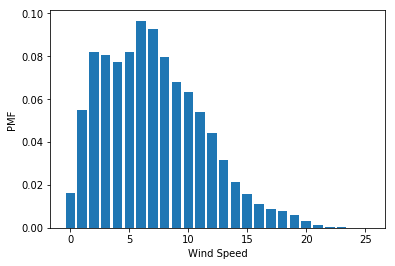

In [84]:

wind=df['ws']
pmf_wind=Pmf.from_seq(wind,normalize=True)
pmf_wind.bar()
plt.ylabel("PMF")
plt.xlabel("Wind Speed")
plt.show()

### Wind Direction
lets analyze that variable

In [19]:
df['wd'].describe()

count    50530.000000
mean       123.188066
std         93.440695
min          0.000000
25%         49.000000
50%         73.000000
75%        201.000000
max        359.000000
Name: wd, dtype: float64

#### The data is in coordinates, lets transform them to  cardinal points.

In [20]:
def condition(value):
    if 22.5 <=value <67.5:
        return 'NE'
    if 67.5 <= value <112.5:
        return 'E'
    if 112.5<= value <157.5:
        return 'SE'
    if 157.5<= value <202.5:
        return 'S'
    if 202.5<= value <247.5:
        return 'SW'
    if 247.5<= value <292.5:
        return 'W'
    if 292.5<= value <337.5:
        return 'NW'
    if 337.5<= value <=360:
        return 'N'
    if 0 <= value <22.5:
        return 'N'
    return value

In [21]:
## Conversion to cardinal points
df['dir']=df['wd'].apply(condition)

In [22]:
df.dtypes

date     datetime64[ns]
ap                int32
ws                int32
tp                int32
wd                int32
hours            object
dir              object
dtype: object

#### As we see on this distribution most of the times the wind is blowing from NE

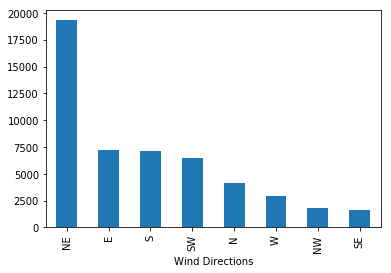

In [82]:
plt.xlabel("Wind Directions")

df['dir'].value_counts().plot(kind='bar')

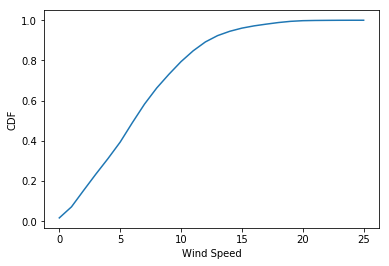

In [24]:
cdf_wind=Cdf.from_seq(df['ws'])
cdf_wind.plot()
plt.xlabel('Wind Speed')
plt.ylabel('CDF')
plt.show()

## With the analysis of this data, what questions could we answer?

With this scatter plot we can see the relationsihp between Wind Speed and Actual Power

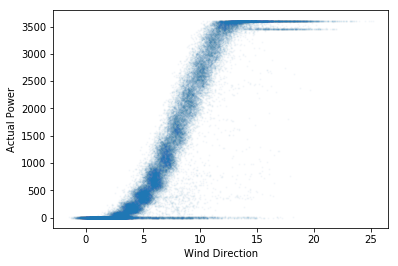

In [81]:
jitter_wind=df['ws']+np.random.normal(0,0.5,size=len(df['ws']))
jitter_ap=df['ap']+np.random.normal(0,2,size=len(df['ap']))
plt.plot(jitter_wind,jitter_ap,'o',markersize=1,alpha=0.03)
plt.xlabel("Wind Direction")
plt.ylabel("Actual Power")
plt.show()

#### Now if doing a correlation between the variables we can see that the value of 0.9 means that there is a strong correlation
#### The more the wind speed, the more power

In [26]:
#correlation
subset=['ap','ws']
df_subset=df[subset]
df_subset.corr()

,ap,ws
ap,1.000000,0.910506
ws,0.910506,1.000000


## Wind Direction and Wind Speed
---
From previous graphs we see that the wind from North East (NE) is the most frequent. Lets observe how it relates to power

                ap           ws           tp           wd          ws2  \
count  2935.000000  2935.000000  2935.000000  2935.000000  2935.000000   
mean    434.379216     4.106985   537.272913   267.828279    24.777513   
std     770.435657     2.812985   859.212690    12.827781    33.512218   
min       0.000000     0.000000     0.000000   248.000000     0.000000   
25%       0.000000     2.000000     0.000000   257.000000     4.000000   
50%      66.000000     4.000000   146.000000   267.000000    16.000000   
75%     495.000000     6.000000   665.000000   278.000000    36.000000   
max    3603.000000    16.000000  3600.000000   292.000000   256.000000   

                wd2  
count   2935.000000  
mean   71896.483135  
std     6909.135322  
min    61504.000000  
25%    66049.000000  
50%    71289.000000  
75%    77284.000000  
max    85264.000000  


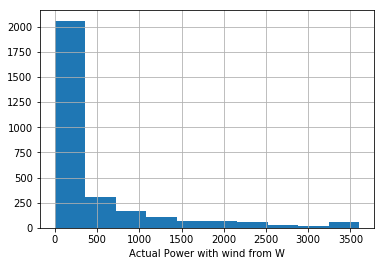

In [80]:
w_ne=df[df['dir']=='W']
print(w_ne.describe())
plt.xlabel("Actual Power with wind from W")


w_ne['ap'].hist()

### From the scatter plot we can se that there is not a linear correlation  the  power generation is stronger  with a wind direction between 0 and 100 degrees and 160 to 250 degress.

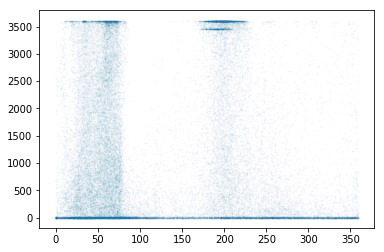

In [28]:
jitter_wind_dir=df['wd']+np.random.normal(0,0.5,size=len(df['wd']))
jitter_ap=df['ap']+np.random.normal(0,2,size=len(df['ap']))
plt.plot(jitter_wind_dir,jitter_ap,'o',markersize=1,alpha=0.02)
plt.show()

### If we compute the correlation, we will observe that is close 0 so there is no linear correlation

In [29]:
#correlation
subset=['ap','wd']
df_subset=df[subset]
df_subset.corr()

,ap,wd
ap,1.000000,-0.062674
wd,-0.062674,1.000000


LinregressResult(slope=-0.8802370231389837, intercept=1415.7263454635674, rvalue=-0.06267376715350607, pvalue=3.6980799920512363e-45, stderr=0.062358138618489774)


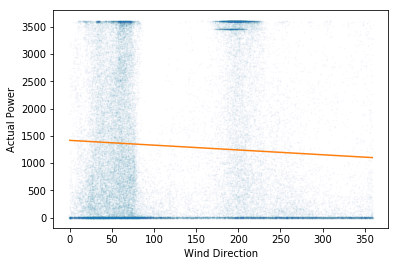

In [78]:
jitter_wind_dir=df['wd']+np.random.normal(0,0.5,size=len(df['wd']))
jitter_ap=df['ap']+np.random.normal(0,2,size=len(df['ap']))
plt.plot(jitter_wind_dir,jitter_ap,'o',markersize=1,alpha=0.02)

res=linregress(df['wd'], df['ap'])
print(res)
fx=np.array([df['wd'].min(), df['wd'].max()])
fy=res.intercept+res.slope*fx
plt.plot(fx,fy,'-')
plt.xlabel("Wind Direction")
plt.ylabel("Actual Power")
plt.show()

### Regression Predictions

In this case we want to predict the Actual Power  given wind speed and wind direction. The resulted model from the method will be use to make the predictions.

The graph show us the Actual Power Mean for each wind speed.

Intercept   -697.648400
wd             0.105072
ws           282.218770
dtype: float64


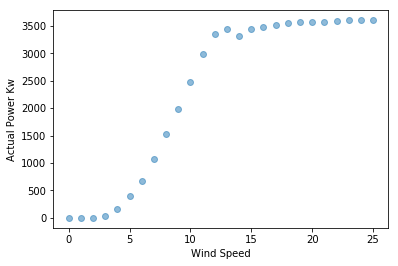

In [76]:
# We run the Regression to predict actual power given wind direction an dws
results=smf.ols('ap ~ wd + ws',data=df).fit()
print(results.params)

#group by speed

group_speed=df.groupby('ws')
mean_ap_by_ws=group_speed['ap'].mean()# get the mean of each group
plt.plot(mean_ap_by_ws,'o',alpha=0.5)
plt.xlabel("Wind Speed")
plt.ylabel("Actual Power Kw")
plt.show()

In [59]:
df['ws2']=df['ws']**2
df['wd2']=df['wd']**2
results=smf.ols('ap ~ wd + ws+wd2+ws2',data=df).fit()
results.params

Intercept   -876.271312
wd             0.705511
ws           328.044227
wd2           -0.001334
ws2           -2.757797
dtype: float64

### Our actual data looks like the dotted graph and our predictions are the straight lines is linear due to the strong correlation between wind speed and actual power.

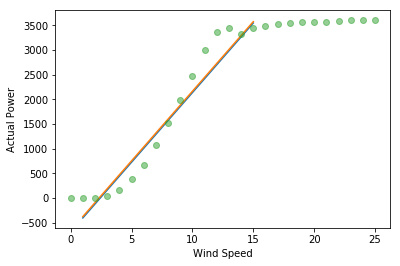

In [77]:
## predictions

# We take our X axis as the wind speed
dp=pd.DataFrame()
dp['ws']=np.linspace(1,15)
dp['ws2']=dp['ws']**2


#Our constant direction of 90
#Will be used to predict the actual power at X Wind speed
dp['wd']=90
dp['wd2']=dp['wd']**2

#We run the prediction
pred_ap=results.predict(dp)

#Plotting the prediction
plt.plot(dp['ws'],pred_ap,label="Wind Direction East")


# We take our X axis as the wind speed

dp2=pd.DataFrame()
dp2['ws']=np.linspace(1,15)
dp2['ws2']=dp2['ws']**2

#Our constant direction of 350
#Will be used to predict the actual power at X Wind speed
dp2['wd']=350
dp2['wd2']=dp2['wd']**2

pred_ap2=results.predict(dp2)
plt.plot(dp2['ws'],pred_ap2,label="Wind Direction East")

plt.plot(mean_ap_by_ws,'o',alpha=0.5)
plt.xlabel("Wind Speed")
plt.ylabel("Actual Power")
plt.show()

### In summary,  the wind speed is proportional to the actual power produced. 20% of the time the wind turbine is not producing energy.  The region predominam wind direction is between NE and E